In [1]:
pip install albumentations


  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl (54.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 635.0 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.14.6
    Uninstalling pydantic_core-2.14.6:
      Successfully uninstalled pydantic_core-2.14.6
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.5.3
    Uninstalling pydantic-2.5.3:
      Successfully uninstalled pydantic-2.5.3
Note: you may need to restart the kernel to use updated packages.


preprocessing

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def preprocess_tensor_image(augmented_image_np, target_size=(224, 224)):
    """
    Preprocesses the augmented image for TensorFlow model input.

    Args:
        augmented_image_np (numpy.ndarray): The augmented image in NumPy array format.
        target_size (tuple): The target size for resizing the image.

    Returns:
        tensor_image (tf.Tensor): Preprocessed TensorFlow tensor image.
    """
    # Denormalize the image if necessary
    augmented_image_np = (augmented_image_np * 255).astype(np.uint8)

    # Convert to TensorFlow tensor
    tensor_image = tf.convert_to_tensor(augmented_image_np, dtype=tf.float32)

    # Resize for consistency
    tensor_image = tf.image.resize(tensor_image, target_size)

    # Preprocess for ResNet (or any other model)
    tensor_image = tf.keras.applications.resnet.preprocess_input(tensor_image)

    return tensor_image

def extract_and_visualize_features(augmented_images):
    """
    Extracts features from the augmented images using ResNet152v2 and visualizes them.

    Args:
        augmented_images (list of tf.Tensor): List of preprocessed images as TensorFlow tensors.
    """
    # Load ResNet152v2 model without the top classification layer
    resnet_model = tf.keras.applications.ResNet152V2(include_top=False, weights='imagenet')

    for i, tensor_image in enumerate(augmented_images):
        # Add batch dimension to the image
        tensor_image = tf.expand_dims(tensor_image, axis=0)

        # Extract features using ResNet152v2
        features = resnet_model(tensor_image)

        # Visualize the feature maps
        visualize_feature_maps(features, image_index=i)

def visualize_feature_maps(features, image_index=0):
    """
    Visualizes the feature maps from a CNN layer.

    Args:
        features (tf.Tensor): Feature maps from the CNN.
        image_index (int): Index of the image for titling the plot.
    """
    # Remove the batch dimension for visualization
    features = tf.squeeze(features, axis=0)

    # Get the number of feature maps
    num_feature_maps = features.shape[-1]

    # Select a few feature maps to visualize (e.g., first 16)
    num_visualizations = min(16, num_feature_maps)
    feature_maps = features[..., :num_visualizations]

    # Plot the feature maps
    plt.figure(figsize=(15, 15))
    for i in range(num_visualizations):
        plt.subplot(4, 4, i + 1)
        plt.imshow(feature_maps[..., i], cmap='viridis')
        plt.axis('off')
        plt.title(f'Feature Map {i + 1}')
    plt.suptitle(f'Feature Maps for Augmented Image {image_index + 1}', fontsize=16)
    plt.show()

# Example usage
image_path = '002.jpeg'



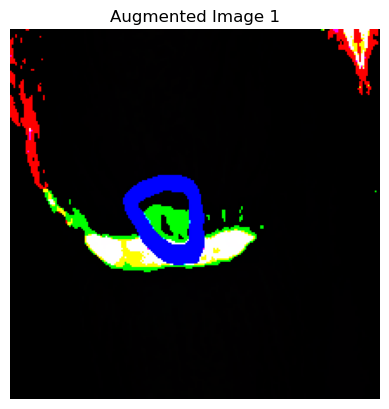

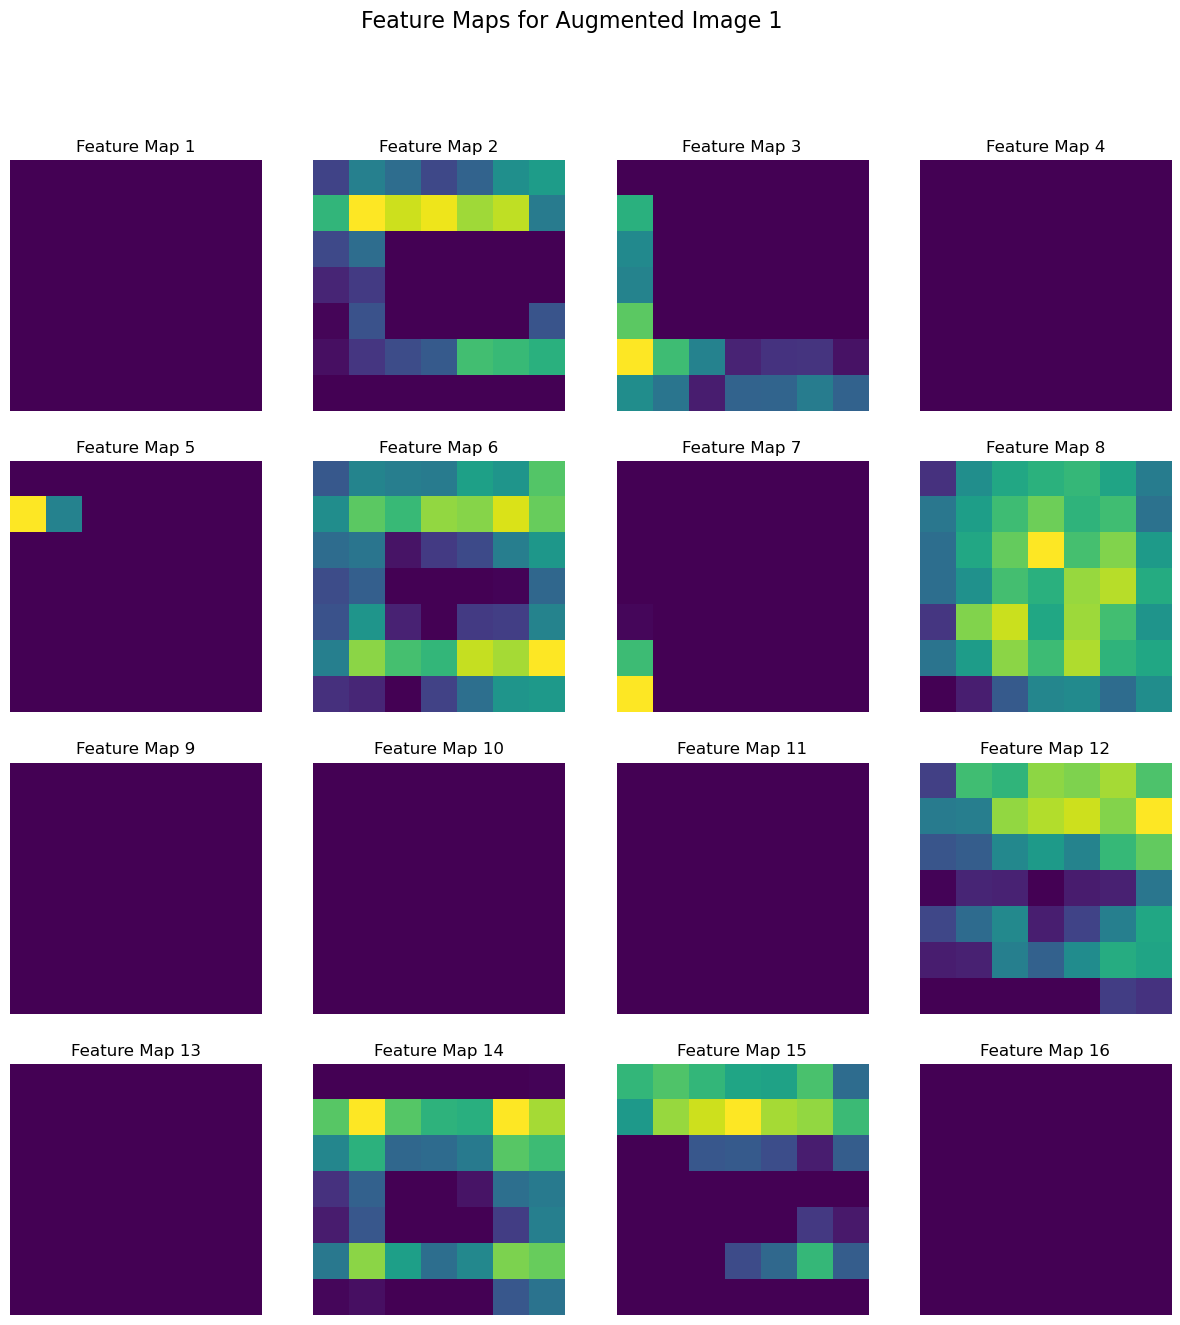

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the transformation pipeline
transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.5),
    A.ElasticTransform(alpha=1.0, sigma=50.0, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

def augment_and_preprocess_images(image_path, num_augmentations=10):
    # Load an image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    augmented_images = []

    # Apply transformations and preprocess each augmented image
    for i in range(num_augmentations):
        # Apply the transformations
        augmented_image = transform(image=image)['image']

        # Convert the augmented image tensor to a NumPy array and transpose to HWC format
        augmented_image_np = augmented_image.permute(1, 2, 0).numpy()

        # Preprocess the augmented image using the new function
        tensor_image = preprocess_tensor_image(augmented_image_np)

        # Append the preprocessed tensor image to the list
        augmented_images.append(tensor_image)

        # Optionally display the augmented image
        plt.subplot(1, num_augmentations, i + 1)
        plt.imshow(augmented_image_np.astype(np.uint8))
        plt.axis('off')
        plt.title(f'Augmented Image {i + 1}')

    plt.show()

    return augmented_images

# Example usage
augmented_tensors = augment_and_preprocess_images(image_path, num_augmentations=1)
extract_and_visualize_features(augmented_tensors)
